Начнем с чтения и подготовки данных

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv("rating.csv")

num_samples = 700_000
data = data.head(num_samples)
data_array = data.values

In [3]:
anime = pd.read_csv("anime.csv")
anime_samples = 1_200
anime = anime[anime["anime_id"] < anime_samples]

Будем хранить все данные в матрице

In [4]:
unique_users = data["user_id"].unique().size
X = np.zeros((unique_users, anime_samples), np.int16)

for rating in data_array:
    if rating[1] <= anime_samples:
        X[rating[0] - 1][rating[1] - 1] = rating[2]

In [5]:
anime_names = ["none"] * anime_samples

for x in anime.values:
    anime_names[x[0] - 1]=x[1]

X_df = pd.DataFrame(X, columns=anime_names)


## Задание №1 : Exploratory analysis (2 балла):

- Распределение числа пользователей по количеству взаимодействий
- Разпределение числа "айтемов" по количеству взаимодействий
- Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"

In [6]:
import seaborn as sns

def get_figure(data):
    sns_plot = sns.distplot(data)
    fig = sns_plot.get_figure()

interactions = np.zeros(unique_users)
interactions_anime = np.zeros(anime_samples)

for i, x in enumerate(X_df.values):
    x = x[x != 0]
    interactions[i] += np.count_nonzero(x)
    
for i in range(anime_samples):
    x = X[:, i]
    x = x[x != 0]
    interactions_anime[i] += np.count_nonzero(x)

X_df["interaction_user"] = interactions
# X_df["interaction_anime"] = interactions_anime

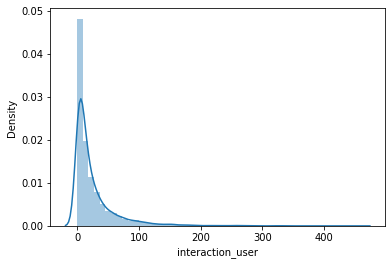

In [7]:
get_figure(X_df["interaction_user"])

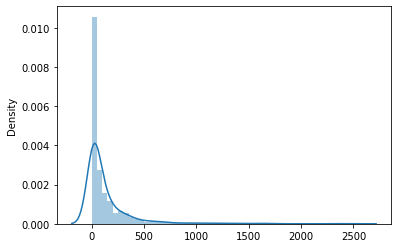

In [8]:
get_figure(interactions_anime)

In [9]:
stats_marks = np.zeros(11) # range 0...10
mean_user_rating = np.zeros(unique_users)
mean_anime_rating = np.zeros(anime_samples)

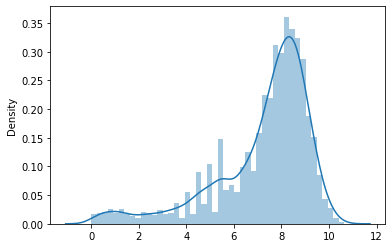

In [10]:
for i, x in enumerate(X_df.values):
    mean_user_rating[i] = np.mean(x[x!=0])
    
get_figure(mean_user_rating[mean_user_rating != 0])

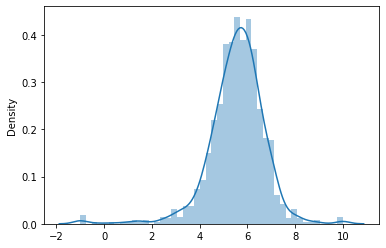

In [11]:
for i in range(anime_samples):
    x = X[:, i]
    x=x[x != 0]
    mean_anime_rating[i] = np.mean(x)
    
get_figure(mean_anime_rating)

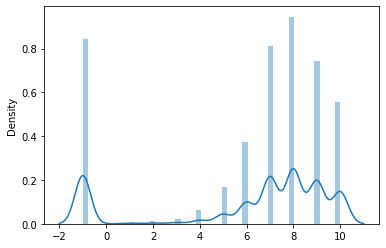

In [12]:
for i in range(11):
    stats_marks[i] = np.count_nonzero(X == i)

stats_marks = stats_marks.astype(np.int64)

get_figure(X[X != 0])


In [13]:
from matplotlib import pyplot as plt

(array([4., 1., 0., 1., 0., 1., 0., 1., 1., 1.]),
 array([  320. ,  3729.6,  7139.2, 10548.8, 13958.4, 17368. , 20777.6,
        24187.2, 27596.8, 31006.4, 34416. ]),
 <BarContainer object of 10 artists>)

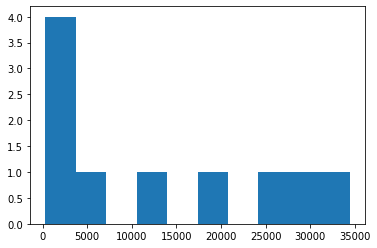

In [14]:
plt.hist(stats_marks[1:])

## Задание №2 : Оценить разреженность данных по рейтингу

У нас уже есть статистика по оценкам на выборке данных. Давайте посмотрим, насколько часто у нас встречаются не нули.

In [15]:
print(X[X != 0].size / X.size)

0.02091818411734952


Всего 2 процента данных это не нули. Данные очень разреженные.

## Задание №3 : Разделить данные на тренировочные и валидационные

In [16]:
train_part = 0.85
train_samples = int(unique_users * 0.85)

X_train = X[:train_samples]
X_val = X[train_samples:]

## Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item

In [17]:
def basic_model(data: "array[n][m], n - users, m - items", n: "number of recommended samples") -> "n ids of most popular anime":
    
    popularity_anime = np.zeros(anime_samples)
    
    for i in range(anime_samples):
        x = data[:, i]
        x=x[x != 0]
        popularity_anime[i] = np.mean(x)
    
    popularity_anime = np.nan_to_num(popularity_anime)
    
    result = np.zeros(n)
    for i in range(n):
        idx = np.argmax(popularity_anime)
        result[i] = idx + 1
        popularity_anime[idx] = 0
        
    return result.astype(np.int32)

In [18]:
basic_model(X_train, 5)

array([ 312,  314,  839, 1058, 1116])

In [19]:
basic_model(X_train, 3)

array([312, 314, 839])

In [20]:
basic_model(X_train, 10)

array([ 312,  314,  839, 1058, 1116,  820,  244,  708, 1021,  313])

## Задание №5 : Решить задачу на основе коллоборативной фильтрации

Будем решать на основе алгоритма SVD. 

In [21]:
from numpy.linalg import svd
import scipy.linalg as la    

In [22]:
class ModelSVD(object):
    
    def __init__(self, data, k=10):
        self.data = data
        self.k = k
        self.data_trained = None
        
    def train(self):
        u, d, v = svd(self.data)
        U = u[:, :self.k]
        D = np.diag(d)[:self.k, :self.k]
        V = v[:self.k, :]
        
        self.data_trained = U @ D @ V
        self.U = U
        self.D = D
        self.V = V
        
    def get_user_factors_for_val(self, data_val):
        u, d, v = svd(data_val)
        U = u[:, :self.k]
        return U
        
    def predict(self, user_factors: "user factors from matrix", n: "count of recommended samples"):
        prediction = user_factors @ self.D @ self.V
        N_recomendations = np.zeros(n)
        
        for i in range(n):
            idx = np.argmax(prediction)
            prediction[idx] = 0
            N_recomendations[i] = idx + 1
            
        return N_recomendations.astype(np.int32)

In [23]:
model = ModelSVD(X_train, 10)

model.train()

# получим факторы пользователей из валидационной выборки
user_val = model.get_user_factors_for_val(X_val)

# порекомендуем пользователю из тестовой выборки 5 аниме, вот такие айди рекомендует модель:
model.predict(user_val[0], 5)

array([199, 164, 431,  30,   1])

## Задание №6 Решить задачу на основе контент-based подхода, выбрав один из методов решения

Решим двумя способами:
- Content-based. Порекомендуем похожие аниме пользователю на основе факторов из предыдущего задания. Потом научим сетку, основанную на всех данных, в том числе и anime.csv
- Натренируем сетку основанную на подходе, напоминающем NCF. Получим эмбединги, и скормим их в качестве факторов модели из первого пункта. 

In [24]:
def mse(A, B):
    return (np.square(A - B)).mean()

def rmse(A, B):
    return np.sqrt(mse(A, B)).mean()

def norm(A, B):
    return np.linalg.norm(A - B)

In [25]:
a=np.random.randn(2, 3)
b=np.random.randn(2, 3)

In [26]:
mse(a, b)

1.3455617967742237

In [27]:
class ContentBasedSVD(object):
    
    def __init__(self, data, k=10):
        self.data = data
        self.k = k
        
    def train(self):
        u, d, v = svd(self.data)
        U = u[:, :self.k]
        D = np.diag(d)[:self.k, :self.k]
        V = v[:self.k, :]
        
        self.data_trained = U @ D @ V
        self.U = U
        self.D = D
        self.V = V
        
    def predict(self, user: "sparse vector of marks", n=5):
        user_liked_factors = np.squeeze(self.V[:, np.nonzero(user)])
        user_liked_count = np.count_nonzero(user)
        
        if user_liked_count == 0:
            return
        rates = np.ones((anime_samples, user_liked_count))
        
        for i in range(anime_samples):
            for j in range(user_liked_count):
                
                rates[i][j] = rmse(self.V[:, i], user_liked_factors[:, j])
                
        rates = np.sum(rates, axis=1)
        rates = np.nan_to_num(1 / rates)
        rates[np.nonzero(user)] = 0
        
        rec = np.argpartition(rates, -n)[-n:]
        
        return rec
        
        
        

In [28]:
# U[0]@D@V

In [29]:
model2 = ContentBasedSVD(X_train, 10)
model2.train()

In [30]:
model2.predict(X_val[0])

array([1007,  367,  759,  971,  106], dtype=int64)

### Перейдем к нейронным сетям

In [31]:
text_columns = ["name", "genre", ]
categorical_columns = ["type", ]
numeric_columns = ["episodes", "rating", "members", ]

anime[categorical_columns] = anime[categorical_columns].fillna('NaN')
anime[text_columns] = anime[text_columns].fillna('NaN')
anime[numeric_columns] = anime[numeric_columns].fillna(0)
anime[numeric_columns] = anime[numeric_columns].replace("Unknown", 0)

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

anime[numeric_columns] = scaler.fit_transform(anime[numeric_columns])

In [33]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
anime[text_columns] = anime[text_columns].applymap(
					lambda x: " ".join(tokenizer.tokenize(x.lower())))

token_counts = Counter()

for col in text_columns:
    for line in anime[col].values:
        token_counts.update(line.split(" "))

min_count = 10

tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = {t: i for i, t in enumerate(tokens)}

UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [34]:
as_matrix(anime.name.array[[100, 101, 102, 103, 104, 105]])

array([[ 0, 54, 12,  0, 59,  0, 59,  0],
       [ 0,  0,  1,  1,  1,  1,  1,  1],
       [ 0, 59,  0,  1,  1,  1,  1,  1],
       [52, 87,  0, 36,  1,  1,  1,  1],
       [ 0,  3,  0,  0,  1,  1,  1,  1],
       [ 0, 27,  0, 12,  0, 58,  0,  0]])

In [35]:
anime_name_tokens = as_matrix(anime.name.array)

NAME = np.zeros((anime_samples, anime_name_tokens.shape[-1]))

In [36]:
for i in range(len(anime_name_tokens)):
    NAME[anime.iloc[i]["anime_id"] - 1] = anime_name_tokens[i]

In [37]:
anime_genre_tokens = as_matrix(anime.genre.array)

GENRE = np.zeros((anime_samples, anime_genre_tokens.shape[-1]))

for i in range(len(anime_genre_tokens)):
    GENRE[anime.iloc[i]["anime_id"] - 1] = anime_genre_tokens[i]

In [38]:
top_categories, top_counts = zip(*Counter(anime["type"]).most_common(1000))
recognized_categories = set(top_categories)
anime["type"] = anime["type"].apply(lambda t: t if t in recognized_categories 
																																else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(anime[categorical_columns].apply(dict, axis=1))

CATEGORICAL = np.zeros((anime_samples, 6)) 
categorical = categorical_vectorizer.transform(anime[categorical_columns].apply(dict, axis=1))

for i in range(len(categorical)):
    CATEGORICAL[anime.iloc[i]["anime_id"] - 1] = categorical[i]

In [39]:
NUMERICAL = np.zeros((anime_samples, len(numeric_columns)))
num = anime[numeric_columns].values

for i in range(len(num)):
    NUMERICAL[anime.iloc[i]["anime_id"] - 1] = num[i]

In [40]:
Dataset_train = [
    [], # U
    [], # V
    [], # NAME
    [], # GENRE
    [], # CATEGORICAL
    [], # NUMERICAL
]

Dataset_val = [
    [], # U
    [], # V
    [], # NAME
    [], # GENRE
    [], # CATEGORICAL
    [], # NUMERICAL
]
Labels_train = []
Labels_val = []

In [41]:
k = 100
u, d, v = svd(X)
U = u[:, :k]
D = np.diag(d)[:k, :k]
V = v[:k, :]

train_size = 120_000
val_size = 30_000

data_array_train, data_array_val = data_array[:train_size], data_array[train_size:train_size + val_size]

In [42]:
for sample in data_array_train:
    user_id = sample[0] - 1
    anime_id = sample[1] - 1
    
    if  anime_id > anime_samples:
        continue
    
    Dataset_train[0].append(U[user_id])
    Dataset_train[1].append(V[:, anime_id])
    Dataset_train[2].append(NAME[anime_id])
    Dataset_train[3].append(GENRE[anime_id])
    Dataset_train[4].append(CATEGORICAL[anime_id])
    Dataset_train[5].append(NUMERICAL[anime_id])
    Labels_train.append(sample[2])
    
for i in range(len(Dataset_train)):
    Dataset_train[i] = np.array(Dataset_train[i])
    
for sample in data_array_val:
    user_id = sample[0] - 1
    anime_id = sample[1] - 1
    
    if  anime_id > anime_samples:
        continue
    
    Dataset_val[0].append(U[user_id])
    Dataset_val[1].append(V[:, anime_id])
    Dataset_val[2].append(NAME[anime_id])
    Dataset_val[3].append(GENRE[anime_id])
    Dataset_val[4].append(CATEGORICAL[anime_id])
    Dataset_val[5].append(NUMERICAL[anime_id])
    Labels_val.append(sample[2])
    
Labels_train = np.array(Labels_train) # > 5
Labels_val = np.array(Labels_val) # > 5
    
for i in range(len(Dataset_val)):
    Dataset_val[i] = np.array(Dataset_val[i])

In [43]:
import torch

def get_batch(data, labels, number, size, device=torch.device("cuda:0")) :
    idxs = list(range(size * number, size * (number + 1)))
    batch = [
        torch.Tensor(data[0][idxs]).to(device),
        torch.Tensor(data[1][idxs]).to(device),
        torch.LongTensor(data[2][idxs]).to(device),
        torch.LongTensor(data[3][idxs]).to(device),
        torch.Tensor(data[4][idxs]).to(device),
        torch.Tensor(data[5][idxs]).to(device),
    ], torch.Tensor(labels[idxs]).to(device).type(torch.float)
    return batch
    
    

In [44]:
get_batch(Dataset_train, Labels_train, 4, 10)

([tensor([[-1.5721e-02,  1.7859e-02,  1.9370e-02,  9.1522e-04, -1.4096e-02,
            2.8021e-02,  2.6889e-02,  1.9232e-02, -2.3888e-02, -7.3522e-03,
            4.6023e-02, -7.5538e-04, -3.6764e-03, -2.0009e-02, -4.1014e-02,
            8.1946e-03, -7.5987e-03,  1.0313e-02, -3.3814e-03, -1.2415e-02,
           -2.5843e-02, -3.1630e-03, -1.2557e-02, -7.6025e-03,  2.4094e-03,
           -4.3698e-03,  1.4779e-02,  3.2915e-03,  1.0142e-02,  1.4053e-02,
            1.6346e-02,  3.7210e-05,  1.0281e-02,  2.4119e-02, -2.6887e-02,
           -6.1125e-04,  1.9450e-03, -6.6458e-03,  6.2159e-03, -1.1319e-02,
            2.9595e-02,  2.3666e-03,  2.1399e-02,  3.3597e-03,  8.5813e-04,
            4.6844e-04, -8.5412e-03,  1.5086e-03,  1.6125e-02,  8.3457e-03,
           -7.4306e-03, -2.0216e-03,  2.1962e-02, -1.2903e-02, -1.8304e-02,
           -2.2242e-03, -6.7978e-03,  3.8347e-02,  2.4488e-02,  5.5030e-03,
           -1.1461e-02,  1.0906e-02,  1.3777e-02,  2.4245e-02, -1.6824e-03,
           -

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [46]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, emb_size=16, voc_size=len(tokens), k=10, linear_size=32):
        super().__init__()
        self.k = k
        self.emb_size = emb_size
        self.voc_size = voc_size
        self.linear_size = linear_size
        
        self.U_linear = nn.Sequential(
            nn.LazyLinear(linear_size * 2),
            nn.ReLU(),
        )
        
        self.V_linear = nn.Sequential(
            nn.LazyLinear(linear_size * 2),
            nn.ReLU(),
        )
        
        self.U_V_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.Embedder = nn.Embedding(voc_size, emb_size)
        
        self.N_encoder = nn.Sequential(
            nn.LazyConv1d(linear_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=linear_size // 2),
            nn.Flatten(start_dim=1),
        )
        
        self.G_encoder = nn.Sequential(
            nn.LazyConv1d(linear_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=linear_size // 2),
            nn.Flatten(start_dim=1),
        )
        
        self.C_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.N2_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.Filter = nn.Sequential(
            nn.LazyLinear(linear_size * 8),
            nn.ReLU(),
            nn.LazyLinear(linear_size * 4),
            nn.ReLU(),
            nn.LazyLinear(1),
#             nn.Sigmoid(),
        )
        
    def forward(self, batch):
        U = batch[0]
        V = batch[1]
        N = batch[2]
        G = batch[3]
        C = batch[4]
        N2 = batch[5]
        
        U_features = self.U_linear(U)
        V_features = self.V_linear(V)
        UV_features = torch.cat([U_features, V_features], dim=1)
        UV_features = self.U_V_linear(UV_features)
        
        N_emb = self.Embedder(N).permute(0, 2, 1)
        G_emb = self.Embedder(G).permute(0, 2, 1)
        
        N_features = self.N_encoder(N_emb)
        G_features = self.G_encoder(G_emb)
        
        C_features = self.C_linear(C)
        N2_features = self.N2_linear(N2)
        
        features = torch.cat(
            [UV_features,
            N_features,
            G_features,
            C_features,
            N2_features,], dim=1
        )
        
        prediction = self.Filter(features)
        
        return prediction
        

In [47]:
d = torch.device("cuda:0")
d1 = torch.device("cpu")
network = NeuralNetwork(linear_size=50).to(d)
# network = SimpleNet(linear_size=64).to(d)

In [48]:
batch = get_batch(Dataset_train, Labels_train, 0, 10, d)

In [49]:
network(batch[0])

tensor([[0.0524],
        [0.0706],
        [0.0513],
        [0.0774],
        [0.0612],
        [0.0516],
        [0.0771],
        [0.0378],
        [0.0572],
        [0.0539]], device='cuda:0', grad_fn=<AddmmBackward>)

In [50]:
def train(model, criterion=nn.MSELoss(), opt=None, epochs=10, lr=0.001):
    batch_size = 128
    stats = []
    if opt is None:
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        # 0.0003
    
    for epoch in range(epochs):
        running_loss = 0
        batch_num = 0
        network.train()
        avg_loss = 0
        while True:
            try:
                batch, labels = get_batch(Dataset_train, Labels_train, batch_num, batch_size)
                batch_num += 1

                outputs = network(batch).squeeze()
                opt.zero_grad()
                loss = criterion(outputs, labels)
                loss.backward()
                opt.step()

                running_loss += loss.item()
                avg_loss += loss.item()
    #             print(f'[{epoch + 1}] loss: {running_loss}')
                running_loss = 0.0
            except Exception:
#                 print(f"Loss: {avg_loss}")
                stats.append(avg_loss)
#                 print("Stop epoch number " + str(epoch + 1))
                break
                
    import matplotlib.pyplot as plt
    print(stats[::12])
    plt.plot(stats, color="red")
    plt.show()

In [64]:
# network = NeuralNetwork(linear_size=64).to(d)
# train(network, epochs=100, lr=0.0001)

In [65]:
# network = NeuralNetwork(linear_size=64).to(d)
# train(network, epochs=200, lr=0.00006)

In [66]:
# network = NeuralNetwork(linear_size=64).to(d)
# train(network, epochs=200, lr=0.00003)

[2730.742398262024, 959.8237608671188, 826.0804055929184, 744.2347003221512, 720.3065579682589, 649.4609103798866, 632.3456457257271, 565.6436706632376, 541.5246422439814]


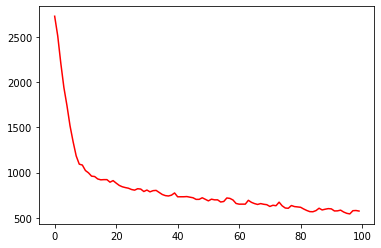

In [67]:
network = NeuralNetwork(linear_size=64).to(d)
train(network, epochs=100, lr=0.001)

In [68]:
val = get_batch(Dataset_val, Labels_val, 11, 16)

In [69]:
network(val[0])

tensor([[6.4729],
        [5.8452],
        [6.6787],
        [7.0115],
        [5.9987],
        [5.0742],
        [6.3422],
        [6.6854],
        [6.8727],
        [5.3651],
        [6.0248],
        [5.8330],
        [6.6986],
        [3.2935],
        [4.6972],
        [6.4202]], device='cuda:0', grad_fn=<AddmmBackward>)

In [70]:
val[1]

tensor([ 9.,  5.,  7., -1., -1.,  6.,  9.,  5.,  7.,  3.,  8.,  6.,  6., -1.,
        -1., -1.], device='cuda:0')

In [71]:
class SimpleNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.U_linear = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
        )
        self.V_linear = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
        )
        self.Filter = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
#             nn.LazyLinear(192),
#             nn.ReLU(),
            nn.LazyLinear(1),
        )
    def forward(self, batch):
        U, V, *oth = batch
        U1 = self.U_linear(U)
        V1 = self.V_linear(V)
        features = torch.cat([U1, V1], dim=1)
        result = self.Filter(features)
        return result

In [72]:
SimpleNet()

SimpleNet(
  (U_linear): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
  )
  (V_linear): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
  )
  (Filter): Sequential(
    (0): LazyLinear(in_features=0, out_features=256, bias=True)
    (1): ReLU()
    (2): LazyLinear(in_features=0, out_features=1, bias=True)
  )
)

In [73]:
xx=U@D@V

In [74]:
h=xx[:150, :150]

<AxesSubplot:>

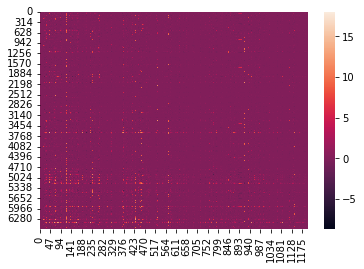

In [75]:
sns.heatmap(xx)

<AxesSubplot:>

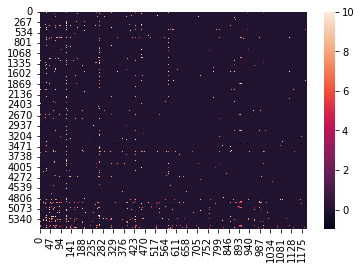

In [76]:
sns.heatmap(X_train)

## Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (Оценим подход SVD и NCF с помощью MAP@k)

In [102]:
uv, dv, vv = svd(X_val)

k = 100
Uv = uv[:, :k]
Dv = np.diag(dv)[:k, :k]
Vv = vv[:k, :]

def get_pred_network(user_id, k=5):
    samples = [[], [], [], [], [], [], ]
    for i in range(anime_samples):
        samples[0].append(Uv[user_id])
        samples[1].append(Vv[:, i])
        samples[2].append(NAME[i])
        samples[3].append(GENRE[i])
        samples[4].append(CATEGORICAL[i])
        samples[5].append(NUMERICAL[i])
#     print(samples)
    for x in range(6):
        samples[x]=np.array(samples[x] )
        
    network.eval()
    
    preds = [0]*anime_samples
    
    bsize = 12
    for x in range(100):
        batch = get_batch(samples, np.zeros(anime_samples), x, bsize)
        out = network(batch[0])
        preds[bsize*x:(x+1)*bsize]=list(out.detach().cpu())
    preds = np.array(preds)
    rec = np.argpartition(preds, -k)[-k:]
    return preds, rec
    

In [103]:
import ml_metrics as ml

In [104]:
ml.mapk([[1, 2], [3, 4]], [[2, 3, 1, 4, 5], [1, 3, 2, 5, 4]])

0.6416666666666666

In [1]:

p=[]
t=[]
for x in range(len(X_val)):
    p.append(list(get_pred_network(x, 5)[1]))
    t.append(list(X_val[x]))

print(ml.mapk(p, t, 5))

0.7821233569261881


#### Выводы по результатам работы:

- Обычный алгоритм SVD показывает себя вполне неплохо, рекомендуя пользователю "схожие по смыслу" аниме. 
- SVD оптимален на небольшом объеме данных. Так как мы взяли 700К семплов, данные получились не такими уж и маленькими, и этого вполне хватило, чтобы показать репрезентативность.
- NFC или нейронная коллаборативная фильтрация показала странные результаты, тем не менее "вяжущиеся" с реальностью. Адекватно она стала работать только при увеличении K до +-100, потому что на векторах из 10 элементов сетка категорически отказывалась обучаться.
- Базовый подход с помощью item-based подхода и факторов SVD вполне адекватен и дает "нормальные" рекомендации. На уровне того, что если вы посмотрели Звездные Воины, вам предложат посмотреть Космическую Одиссею.